# Shoe Brand Classification Using CNN and ResNet

## Unzip Input Data

In [ ]:
!unzip shoes.zip

## Import Necessary Libraries 

In [43]:
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn as nn
from sklearn.metrics import accuracy_score
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load Data

In [19]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='shoes/train', transform=transform_test)
test_dataset = datasets.ImageFolder(root='shoes/test', transform=transform_test)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


## Show Sample Images

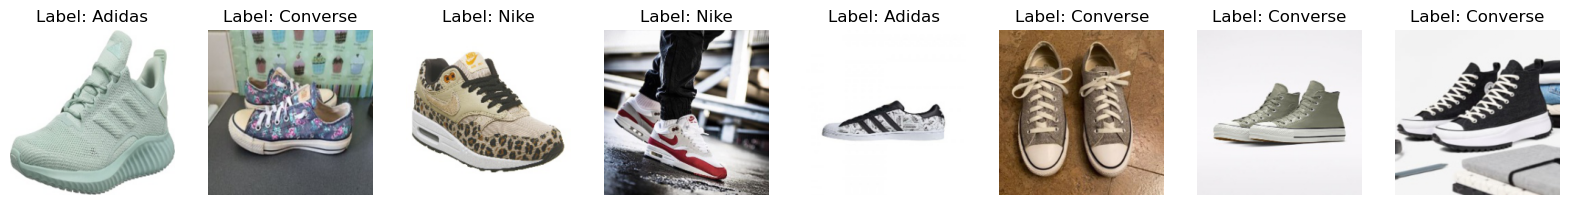

In [53]:
def show_images(loader):
    label_map = {0: 'Adidas', 1: 'Converse', 2: 'Nike'}
    for images, labels in loader:
        fig, axes = plt.subplots(1, 8, figsize=(20, 5))
        for i, ax in enumerate(axes):
            ax.imshow(images[i].permute(1, 2, 0))
            ax.set_title(f"Label: {label_map[labels[i].item()]}")
            ax.axis('off')
        plt.show()
        break

show_images(train_loader)

## Define CNN Model

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.05),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(256 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, 3)  # 3 classes: Nike, Adidas, Converse
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

## Train Model

In [21]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using {device}")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [22]:
n_epochs = 20
train_loss_history = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}")


Epoch 1/20, Train Loss: 1.0952
Epoch 2/20, Train Loss: 1.0645
Epoch 3/20, Train Loss: 1.0368
Epoch 4/20, Train Loss: 0.9912
Epoch 5/20, Train Loss: 0.9424
Epoch 6/20, Train Loss: 0.8914
Epoch 7/20, Train Loss: 0.8447
Epoch 8/20, Train Loss: 0.7843
Epoch 9/20, Train Loss: 0.7173
Epoch 10/20, Train Loss: 0.6511
Epoch 11/20, Train Loss: 0.5832
Epoch 12/20, Train Loss: 0.5303
Epoch 13/20, Train Loss: 0.4915
Epoch 14/20, Train Loss: 0.4132
Epoch 15/20, Train Loss: 0.3788
Epoch 16/20, Train Loss: 0.3145
Epoch 17/20, Train Loss: 0.2817
Epoch 18/20, Train Loss: 0.2099
Epoch 19/20, Train Loss: 0.1944
Epoch 20/20, Train Loss: 0.1531


## Plot Training Loss

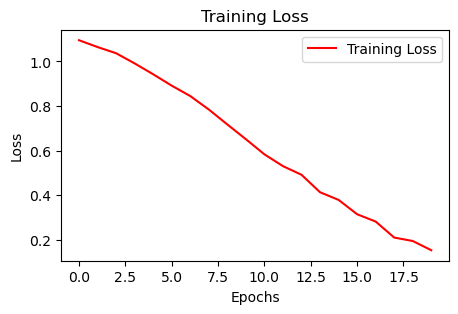

In [27]:
plt.figure(figsize=(5, 3))
plt.plot(train_loss_history, label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## Evaluate Model

In [30]:
model.eval()

predictions = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        
        predictions.extend(predicted.cpu().numpy())
        labels.extend(target.cpu().numpy())

accuracy = accuracy_score(labels, predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 54.39%


## Changing Hyperparameters - Learning Rate

In [31]:
model_2 = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01)

In [32]:
n_epochs = 20
train_loss_history_2 = []

for epoch in range(n_epochs):
    model_2.train()
    train_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model_2(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_loss_history_2.append(train_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/20, Train Loss: 1.1039
Epoch 2/20, Train Loss: 1.0618
Epoch 3/20, Train Loss: 0.9722
Epoch 4/20, Train Loss: 0.8627
Epoch 5/20, Train Loss: 0.7162
Epoch 6/20, Train Loss: 0.5049
Epoch 7/20, Train Loss: 0.3133
Epoch 8/20, Train Loss: 0.1879
Epoch 9/20, Train Loss: 0.1293
Epoch 10/20, Train Loss: 0.0924
Epoch 11/20, Train Loss: 0.0277
Epoch 12/20, Train Loss: 0.0070
Epoch 13/20, Train Loss: 0.0031
Epoch 14/20, Train Loss: 0.0026
Epoch 15/20, Train Loss: 0.0015
Epoch 16/20, Train Loss: 0.0011
Epoch 17/20, Train Loss: 0.0011
Epoch 18/20, Train Loss: 0.0010
Epoch 19/20, Train Loss: 0.0008
Epoch 20/20, Train Loss: 0.0005


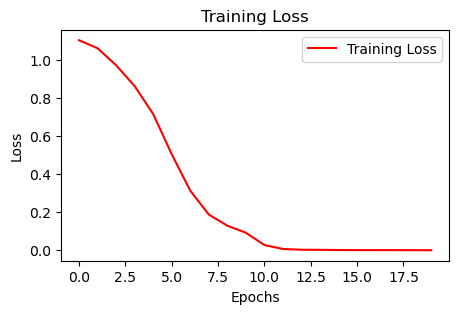

In [33]:
plt.figure(figsize=(5, 3))
plt.plot(train_loss_history_2, label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [34]:
model_2.eval()

predictions_2 = []
labels_2 = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model_2(data)
        _, predicted = torch.max(outputs, 1)
        
        predictions_2.extend(predicted.cpu().numpy())
        labels_2.extend(target.cpu().numpy())

accuracy = accuracy_score(labels_2, predictions_2)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 52.63%


## Changing Hyperparameters - Dropout Rate

In [36]:
class CNN(nn.Module):
    def __init__(self, dropout_rate_conv=0.2, dropout_rate_fc=0.3):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate_conv),  # Changed dropout rate
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(dropout_rate_fc),  # Changed dropout rate
            nn.Linear(256 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate_fc),  # Changed dropout rate
            nn.Linear(512, 3)  # 3 classes: Nike, Adidas, Converse
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x


In [37]:
model_3 = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.001)

In [38]:
n_epochs = 20
train_loss_history_3 = []

for epoch in range(n_epochs):
    model_3.train()
    train_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model_3(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_loss_history_3.append(train_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/20, Train Loss: 1.0917
Epoch 2/20, Train Loss: 1.0727
Epoch 3/20, Train Loss: 1.0475
Epoch 4/20, Train Loss: 1.0323
Epoch 5/20, Train Loss: 0.9916
Epoch 6/20, Train Loss: 0.9589
Epoch 7/20, Train Loss: 0.9191
Epoch 8/20, Train Loss: 0.8930
Epoch 9/20, Train Loss: 0.8547
Epoch 10/20, Train Loss: 0.8172
Epoch 11/20, Train Loss: 0.7664
Epoch 12/20, Train Loss: 0.7228
Epoch 13/20, Train Loss: 0.6785
Epoch 14/20, Train Loss: 0.6312
Epoch 15/20, Train Loss: 0.6062
Epoch 16/20, Train Loss: 0.5337
Epoch 17/20, Train Loss: 0.4723
Epoch 18/20, Train Loss: 0.4382
Epoch 19/20, Train Loss: 0.3966
Epoch 20/20, Train Loss: 0.3352


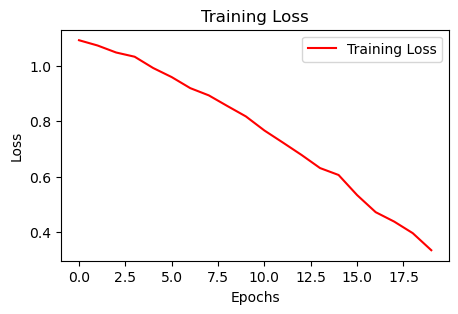

In [39]:
plt.figure(figsize=(5, 3))
plt.plot(train_loss_history_3, label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [40]:
model_3.eval()

predictions_3 = []
labels_3 = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model_3(data)
        _, predicted = torch.max(outputs, 1)
        
        predictions_3.extend(predicted.cpu().numpy())
        labels_3.extend(target.cpu().numpy())

accuracy = accuracy_score(labels_3, predictions_3)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 62.28%


## Comparing Models

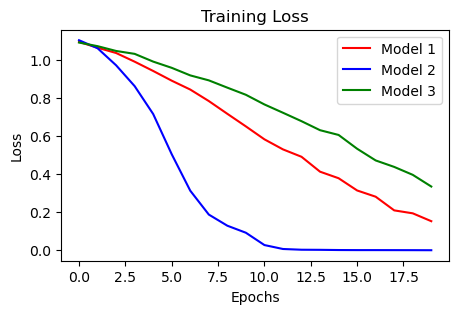

In [41]:
plt.figure(figsize=(5, 3))
plt.plot(train_loss_history, label='Model 1', color='red')
plt.plot(train_loss_history_2, label='Model 2', color='blue')
plt.plot(train_loss_history_3, label='Model 3', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## Approaching an accuracy of more than 86%

In [44]:
transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

transform_flip_horizontal = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor()
])


train_dataset_original = datasets.ImageFolder(
    root='shoes/train',
    transform=transform_original
)

train_dataset_flip_horizontal = datasets.ImageFolder(
    root='shoes/train',
    transform=transform_flip_horizontal
)

final_train_dataset = ConcatDataset([
    train_dataset_original,
    train_dataset_flip_horizontal,
])

final_test_dataset = datasets.ImageFolder(
    root='shoes/test',
    transform=transform_original
)

final_train_loader = DataLoader(final_train_dataset, batch_size=12, shuffle=True, num_workers=2)
final_test_loader = DataLoader(final_test_dataset, batch_size=12, shuffle=False, num_workers=2)

## Enhanced ResNet Model

In [45]:
class EnhancedResNet(nn.Module):
    def __init__(self):
        super(EnhancedResNet, self).__init__()
        
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        return self.resnet(x)

final_model = EnhancedResNet().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/foad/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [01:14<00:00, 1.38MB/s]


## Train Enhanced ResNet Model

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.resnet.fc.parameters(), lr=0.0001, weight_decay=0.001)

In [49]:
n_epochs = 30
final_train_loss_history = []

for epoch in range(n_epochs):
    final_model.train()
    train_loss = 0.0
    
    for data, target in tqdm(final_train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = final_model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(final_train_loader)
    final_train_loss_history.append(train_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}")


100%|██████████| 119/119 [00:27<00:00,  4.34it/s]


Epoch 1/30, Loss: 0.9923


100%|██████████| 119/119 [00:25<00:00,  4.68it/s]


Epoch 2/30, Loss: 0.7683


100%|██████████| 119/119 [00:27<00:00,  4.33it/s]


Epoch 3/30, Loss: 0.6978


100%|██████████| 119/119 [02:03<00:00,  1.04s/it]


Epoch 4/30, Loss: 0.6285


100%|██████████| 119/119 [00:54<00:00,  2.20it/s]


Epoch 5/30, Loss: 0.5884


100%|██████████| 119/119 [00:59<00:00,  2.02it/s]


Epoch 6/30, Loss: 0.5569


100%|██████████| 119/119 [01:12<00:00,  1.63it/s]


Epoch 7/30, Loss: 0.5420


100%|██████████| 119/119 [01:13<00:00,  1.62it/s]


Epoch 8/30, Loss: 0.5190


100%|██████████| 119/119 [01:01<00:00,  1.94it/s]


Epoch 9/30, Loss: 0.5158


100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


Epoch 10/30, Loss: 0.5092


100%|██████████| 119/119 [00:42<00:00,  2.78it/s]


Epoch 11/30, Loss: 0.4596


100%|██████████| 119/119 [00:48<00:00,  2.48it/s]


Epoch 12/30, Loss: 0.4641


100%|██████████| 119/119 [00:49<00:00,  2.41it/s]


Epoch 13/30, Loss: 0.4664


100%|██████████| 119/119 [00:48<00:00,  2.45it/s]


Epoch 14/30, Loss: 0.4297


100%|██████████| 119/119 [00:44<00:00,  2.66it/s]


Epoch 15/30, Loss: 0.4359


100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


Epoch 16/30, Loss: 0.4170


100%|██████████| 119/119 [00:44<00:00,  2.66it/s]


Epoch 17/30, Loss: 0.3925


100%|██████████| 119/119 [00:49<00:00,  2.41it/s]


Epoch 18/30, Loss: 0.4084


100%|██████████| 119/119 [00:48<00:00,  2.46it/s]


Epoch 19/30, Loss: 0.3966


100%|██████████| 119/119 [00:46<00:00,  2.53it/s]


Epoch 20/30, Loss: 0.4048


100%|██████████| 119/119 [00:59<00:00,  2.00it/s]


Epoch 21/30, Loss: 0.4145


100%|██████████| 119/119 [00:47<00:00,  2.53it/s]


Epoch 22/30, Loss: 0.4229


100%|██████████| 119/119 [00:48<00:00,  2.44it/s]


Epoch 23/30, Loss: 0.3484


100%|██████████| 119/119 [00:56<00:00,  2.09it/s]


Epoch 24/30, Loss: 0.3746


100%|██████████| 119/119 [00:58<00:00,  2.03it/s]


Epoch 25/30, Loss: 0.3652


100%|██████████| 119/119 [00:53<00:00,  2.24it/s]


Epoch 26/30, Loss: 0.3521


100%|██████████| 119/119 [00:58<00:00,  2.03it/s]


Epoch 27/30, Loss: 0.3484


100%|██████████| 119/119 [00:59<00:00,  2.00it/s]


Epoch 28/30, Loss: 0.3283


100%|██████████| 119/119 [00:56<00:00,  2.12it/s]


Epoch 29/30, Loss: 0.3244


100%|██████████| 119/119 [00:58<00:00,  2.05it/s]

Epoch 30/30, Loss: 0.3527


## Plot Training Loss

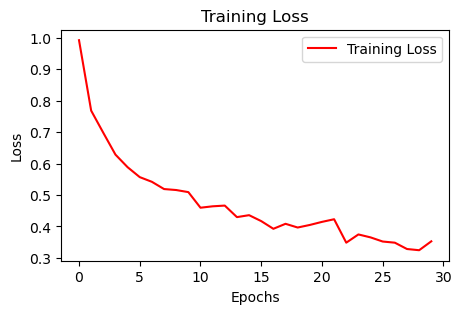

In [50]:
plt.figure(figsize=(5, 3))
plt.plot(final_train_loss_history, label='Training Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

## Evaluate Enhanced ResNet Model

In [51]:
final_model.eval()
final_predictions = []
final_labels = []
test_loss = 0.0

with torch.no_grad():
    for data, labels in tqdm(final_test_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = final_model(data)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        final_predictions.extend(preds.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(final_labels, final_predictions)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 10/10 [00:12<00:00,  1.30s/it]

Test Accuracy: 88.09%
